## Variant 3 (Fear Greed + Markov Switching)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

### Data Collection

In [2]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

# Market-related data
market_data = yf.download("VOO", start=start_date, end=end_date, auto_adjust=True)
market_data['Returns'] = np.log(market_data['Close'] / market_data['Close'].shift(1))  # Log returns
market_returns = market_data['Returns']
market_data = market_data.dropna()
market_prices = yf.download("VOO", start=start_date, end=end_date)
market_prices = market_prices["Close"]

# Ticker-related data
data = yf.download(tickers, start=start_date, end=end_date)
closing_prices = data["Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_capitalisation(tickers):
    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_caps

data.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


Price            Close                                                \
Ticker             AMD        AMZN       INTC        META       NVDA   
Date                                                                   
2023-12-15  139.149994  149.970001  45.549953  333.645508  48.876141   
2023-12-18  138.899994  154.070007  45.086170  343.308594  50.062801   
2023-12-19  140.149994  153.789993  46.043346  349.026764  49.589939   
2023-12-20  135.470001  152.119995  45.155243  347.950836  48.097359   
2023-12-21  139.910004  153.839996  46.457802  352.742523  48.976116   
2023-12-22  139.600006  153.419998  47.365639  352.045227  48.816162   
2023-12-26  143.410004  153.410004  49.832600  353.479736  49.265030   
2023-12-27  146.070007  153.339996  50.089161  356.468323  49.402988   
2023-12-28  148.759995  153.380005  49.724052  356.956451  49.507965   
2023-12-29  147.410004  151.940002  49.585903  352.613037  49.507965   

Price                                    High                         ...  \
Ticker           RIVN        TSLA         AMD        AMZN       INTC  ...   
Date                                                                  ...   
2023-12-15  22.830000  253.500000  140.889999  150.570007  46.645284  ...   
2023-12-18  23.799999  252.080002  139.789993  154.850006  45.619035  ...   
2023-12-19  24.350000  257.220001  143.470001  155.119995  46.063083  ...   
2023-12-20  23.180000  247.139999  139.580002  155.630005  46.329519  ...   
2023-12-21  23.580000  254.500000  139.979996  153.970001  46.497270  ...   
2023-12-22  23.209999  252.539993  140.699997  154.350006  47.523524  ...   
2023-12-26  23.590000  256.609985  143.850006  153.979996  49.852336  ...   
2023-12-27  23.730000  261.440002  146.250000  154.779999  50.602289  ...   
2023-12-28  23.540001  253.179993  150.410004  154.080002  50.197708  ...   
2023-12-29  23.459999  248.479996  151.050003  153.889999  49.901674  ...   

Price            Open                           Volume                       \
Ticker           NVDA       RIVN        TSLA       AMD       AMZN      INTC   
Date                                                                          
2023-12-15  48.180339  22.750000  251.210007  70178600  110039100  84553800   
2023-12-18  49.385995  22.600000  253.779999  45199500   62512800  27895700   
2023-12-19  49.409990  23.959999  253.479996  63739800   43171300  35358800   
2023-12-20  49.640920  24.049999  256.410004  54671700   50322100  38159100   
2023-12-21  48.797166  23.540001  251.899994  47179400   36305700  28320500   
2023-12-22  49.181057  23.730000  256.760010  35370400   29480100  30053700   
2023-12-26  48.954117  23.469999  254.490005  47157400   25067200  60287400   
2023-12-27  49.496964  23.799999  258.350006  49033400   31434700  52148000   
2023-12-28  49.628933  23.680000  263.660004  63800700   27057000  27705200   
2023-12-29  49.798883  23.600000  255.100006  62028200   39789000  29266500   

Price                                                   
Ticker          META       NVDA        RIVN       TSLA  
Date                                                    
2023-12-15  30001600  479948000  58996600.0  135720800  
2023-12-18  18993900  412587000  46402300.0  116416500  
2023-12-19  17729400  464444000  37545500.0  106737400  
2023-12-20  16369900  397894000  38421000.0  125097000  
2023-12-21  15289600  300425000  27720800.0  109594200  
2023-12-22  11764200  252507000  23959000.0   93249800  
2023-12-26   9898600  244200000  30450100.0   86892400  
2023-12-27  13207900  233648000  22593300.0  106494400  
2023-12-28  11798800  246587000  25289500.0  113619900  
2023-12-29  14980500  389293000  21327900.0  100615300  

[10 rows x 35 columns]

In [3]:
closing_prices.tail(10)

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15,139.149994,149.970001,45.549953,333.645508,48.876141,22.830000,253.500000
2023-12-18,138.899994,154.070007,45.086170,343.308594,50.062801,23.799999,252.080002
2023-12-19,140.149994,153.789993,46.043346,349.026764,49.589939,24.350000,257.220001
2023-12-20,135.470001,152.119995,45.155243,347.950836,48.097359,23.180000,247.139999
2023-12-21,139.910004,153.839996,46.457802,352.742523,48.976116,23.580000,254.500000
2023-12-22,139.600006,153.419998,47.365639,352.045227,48.816162,23.209999,252.539993
2023-12-26,143.410004,153.410004,49.832600,353.479736,49.265030,23.590000,256.609985
2023-12-27,146.070007,153.339996,50.089161,356.468323,49.402988,23.730000,261.440002
2023-12-28,148.759995,153.380005,49.724052,356.956451,49.507965,23.540001,253.179993


The covariance matrix of asset returns is calculated, from which the covariance and correlation plots are displayed. Both plots are derived from the same data, however the latter provides better visualisation of asset covariances.

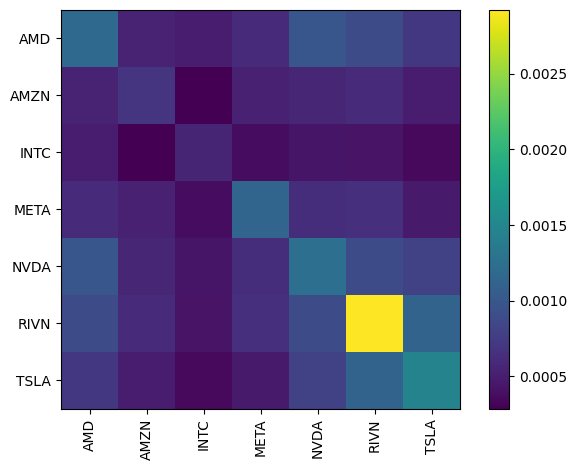

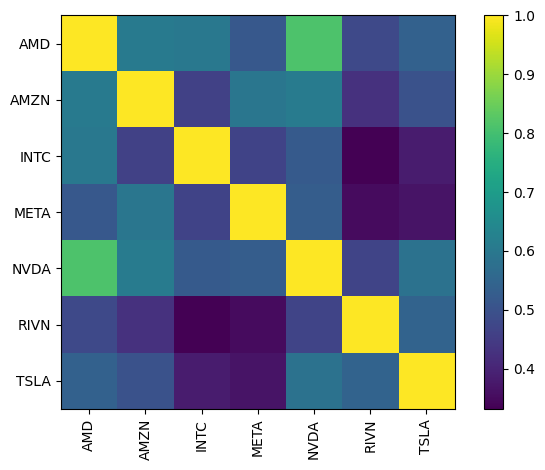

In [4]:
covariance_matrix = returns.cov()

covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

The dataframe for the above covariance matrices can be seen below for further clarity of how returns correlate between assets.

In [5]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

Using the previously defined function, market prices from the Vanguard S&P 500 index and market capitalisations for each ticker can be retrieved. These are used to calculate the 'Prior' and 'Delta'.

<li>Delta represents the risk-aversion co-efficient, and is used to scale the equilibrium returns. This determines the risk aversion of the investor.
<li>Prior is used to calculate the equilibrium returns based on the market portfolio (VOO). This is the benchmark portfolio which will be skewed once investor views are provided in the following section.

In [6]:
market_caps = get_market_capitalisation(tickers)

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior

Ticker
AMD     0.003118
AMZN    0.002401
INTC    0.001552
META    0.002852
NVDA    0.003590
RIVN    0.003259
TSLA    0.002966
dtype: float64

### Market Logarithmic Returns

The logarithmic returns are then plotted to gauge a better understanding of the percentage change of returns of an asset over the 10-year period.

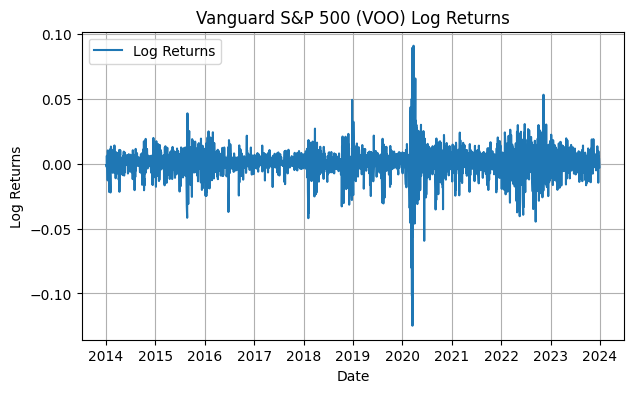

In [7]:
def plot_log_returns(market_data):
    """
    Plots the logarithmic returns of the Vanguard S&P 500 ETF (VOO) over a 10-year date period.

    Parameters:
        market_data (pd.DataFrame): DataFrame containing market data with a 'Returns' column for log returns
    """
    plt.figure(figsize=(7,4))
    plt.plot(market_data.index, market_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

plot_log_returns(market_data)

### Calculate All Sentiment Indicators

In [8]:
def calculate_stock_rsi(tickers, period=14):
    """
    Calculates the Relative Strength Index (RSI) values for a list of stocks. 
    Used as a momentum indicator to analyse recent overbought or oversold conditions 
    and the general trend (upward/downward) for a given stock.

    Parameters:
    tickers: list of str
        List of stock tickers.
    period: int
        Lookback period for RSI

    Returns:
    rsi_dict: dict
        Dictionary of tickers with their corresponding RSI value. Higher values indicate
        a stronger upward trend, versus lower values indicating a downtrend.
    """
    if not isinstance(tickers, list):
        print("Tickers must be a list of strings")
        return None

    rsi_dict = {}
    for ticker in tickers:
        try:
            stock_data = yf.Ticker(ticker).history(period="1y")

            stock_data['Change'] = stock_data['Close'].diff()

            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            rsi_dict[ticker] = stock_data['RSI'].iloc[-1]
        
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None

    return rsi_dict

def calculate_stock_price_strength(tickers, period=52):
    """
    Calculates the Relative Price Strength, indicating whether the stock
    is currently outperforming the market (used as a benchmark) based on the
    price in proximity with its 52-week high.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    price_strength_dict: dict
        Tuple of tickers with their corresponding price strength value, including
        price strength, high, low, and current price or 'None' if the value is 0.
    """
    price_strength_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")

            high = stock_data['High'].max()
            low = stock_data['Low'].min()
            current_price = stock_data['Close'].iloc[-1]

            # Proximity to 52-week high
            price_strength = (current_price - low) / (high - low) if high - low != 0 else None

            price_strength_dict[ticker] = (price_strength, high, low, current_price)

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price strength")
            price_strength_dict[ticker] = None

    return price_strength_dict

def calculate_stock_price_breadth(tickers):
    """
    Calculates the Stock Price Breadth which indicates the advancing
    versus declining stock price.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    breadth_ratios: dict
        Dictionary of tickers with their corresponding breadth ratio.
    """
    breadth_ratios = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker)
            prior_year_history = stock_data.history(period="1y")

            close_data = prior_year_history['Close'].tolist()
            volume_data = prior_year_history['Volume'].tolist()

            rising_vol = 0
            declining_vol = 0

            for i in range(1, len(close_data)):
                price_change = close_data[i] - close_data[i - 1]
                if price_change > 0:
                    rising_vol += volume_data[i]
                elif price_change < 0:
                    declining_vol += volume_data[i]

            # edge case for declining_vol == 0
            if declining_vol == 0:
                breadth_ratio = float('inf') if rising_vol > 0 else 0
            else:
                breadth_ratio = rising_vol / declining_vol

            breadth_ratios[ticker] = breadth_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error}")
            breadth_ratios[ticker] = None

    return breadth_ratios

def calculate_market_volatility(tickers):
    """
    Calculates annual market volatility for a given list tickers 
    based on a rolling 50 day standard deviation of daily returns.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    volatility_dict: dict
        Dictionary of tickers with their corresponding annual
        volatility value. For any errors, this is set to 'None'.
    """
    volatility_dict = {}

    for ticker in tickers:
        try:
            ticker = ticker.upper()
            stock_data = yf.Ticker(ticker).history(period="1y")
            stock_data['Returns'] = stock_data['Close'].pct_change()
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
            latest_volatility = stock_data['Volatility'].iloc[-1]
            volatility_dict[ticker] = latest_volatility

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating volatility")
            volatility_dict[ticker] = None

    return volatility_dict

def calculate_put_call_ratio(tickers):
    """
    Calculates the put-call ratio for a given list of tickers
    based on the volume of options.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    put_call_dict: dict
        Dictionary of tickers with their corresponding put-call ratio, 
        calculated as the total put volume divided by total call volume.
        For any errors, this is set to 'None'.
    """
    put_call_dict = {}
    
    for ticker in tickers:
        try:
            # get options chain for ticker
            options = yf.Ticker(ticker).option_chain()
            puts = options.puts
            calls = options.calls

            # total volume
            total_put_volume = puts['volume'].sum()
            total_call_volume = calls['volume'].sum()

            # calculate ratio
            put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None
            put_call_dict[ticker] = put_call_ratio

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating put-call ratio")
            put_call_dict[ticker] = None
    
    return put_call_dict

### Get Stock-Specific Fear-Greed Score

In [9]:
def get_fear_greed(tickers):
    """
    Calculates an overarching fear-greed score based on the individual
    stock sentiment indicators. First retrieves individual values, then
    normalises each value to the same scale. Sets the weight of each indicator,
    then times this by the respective normalised value.

    Parameters:
    tickers: list of str
        List of stock tickers.

    Returns:
    fear_greed_scores_dict: dict
        Dictionary of tickers with their corresponding amalgamated fear-greed score.
        For any errors, this is set to 'None'.
    """
    fear_greed_scores_dict = {}

    # call individual sentiment function
    rsi_dict = calculate_stock_rsi(tickers)
    price_strength_dict = calculate_stock_price_strength(tickers)
    breadth_dict = calculate_stock_price_breadth(tickers)
    volatility_dict = calculate_market_volatility(tickers)
    put_call_ratio_dict = calculate_put_call_ratio(tickers)

    for ticker in tickers:
        try:
            # get all dict values
            rsi = rsi_dict.get(ticker, None)
            price_strength_tuple = price_strength_dict.get(ticker, None)  # Get the whole tuple
            breadth_ratio = breadth_dict.get(ticker, None)
            volatility = volatility_dict.get(ticker, None)
            put_call_ratio = put_call_ratio_dict.get(ticker, None)

            # get price_strength from tuple (price_strength, high, low, current_price)
            price_strength = price_strength_tuple[0] if price_strength_tuple else None

            # normalize each indicator with validation
            normalised_rsi = float(rsi) / 100 if rsi is not None and isinstance(rsi, (int, float)) else 0.5
            normalised_price_strength = float(price_strength) if price_strength is not None and isinstance(price_strength, (int, float)) else 0.5
            normalised_breadth = min(max(float(breadth_ratio) / 2, 0), 1) if breadth_ratio is not None and isinstance(breadth_ratio, (int, float)) else 0.5
            normalised_volatility = min(max(float(volatility) / 100, 0), 1) if volatility is not None and isinstance(volatility, (int, float)) else 0.5
            normalised_put_call_ratio = min(max(float(put_call_ratio), 0), 1) if put_call_ratio is not None and isinstance(put_call_ratio, (int, float)) else 0.5

            print(f"Ticker: {ticker}, RSI: {normalised_rsi}, Strength: {normalised_price_strength}, Breadth: {normalised_breadth}, Volatility: {normalised_volatility}, Put-Call: {normalised_put_call_ratio}")

            # equal weights for each indicator
            rsi_weight = 0.2
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

fear_greed_scores_dict = get_fear_greed(tickers)

print(f"\nFear-Greed Scores:\n {fear_greed_scores_dict}")

Ticker: TSLA, RSI: 0.28344277078331076, Strength: 0.44084178393364803, Breadth: 0.5508019922795904, Volatility: 0.006190803655254573, Put-Call: 0.8669394431020292
Ticker: NVDA, RSI: 0.4503030641180284, Strength: 0.6361965185479468, Breadth: 0.5423310603264594, Volatility: 0.0064257113434983545, Put-Call: 0.9249381310344026
Ticker: AMZN, RSI: 0.27855084353991133, Strength: 0.6673632793420745, Breadth: 0.5551054207530691, Volatility: 0.0026430232291236306, Put-Call: 0.3446040723257348
Ticker: META, RSI: 0.33797395224193394, Strength: 0.7780181998297607, Breadth: 0.5688505153165538, Volatility: 0.002705067325811235, Put-Call: 0.6361440580766169
Ticker: RIVN, RSI: 0.4510703899040026, Strength: 0.33789524829828305, Breadth: 0.5093086757875434, Volatility: 0.008172301317268225, Put-Call: 0.21581712883059104
Ticker: INTC, RSI: 0.643878174820079, Strength: 0.1888661415241652, Breadth: 0.48715533264507344, Volatility: 0.006243318610094011, Put-Call: 0.5752302834156632
Ticker: AMD, RSI: 0.341040

In [10]:
# Get a total sum of all the fear-greed scores
total = sum(fear_greed_scores_dict.values())

# Normalize the values to equate to 1 for each ticker
# and print subsequenet values
normalized_values = {ticker: (value / total) for ticker, value in fear_greed_scores_dict.items()} # normalise to equate to 1
print(normalized_values)

# Add to dataframe for easier visualisation
fg_scores_df = pd.DataFrame.from_dict(normalized_values, orient='index', columns=['Normalised Fear-Greed Score'])
fg_scores_array = np.array(list(normalized_values.values()))

fg_scores_df

{'TSLA': 0.1576231081069844, 'NVDA': 0.1878515303091316, 'AMZN': 0.13561458653830274, 'META': 0.1704983983587311, 'RIVN': 0.11169447301930605, 'INTC': 0.13951122734348223, 'AMD': 0.0972066763240619}


,Normalised Fear-Greed Score
TSLA,0.157623
NVDA,0.187852
AMZN,0.135615
META,0.170498
RIVN,0.111694
INTC,0.139511
AMD,0.097207


### Fit Markov-Switching Model

The Markov Switching model is then fitted to the market data, specifically the same logarithmic returns as above, using the Vanguard S&P 500 ETF. This allows you to define the number of regimes (in this case, two regimes are set, to correspond with bullish/bearish market states) - the model determines periods of high and low volatility in the market data, which subsequently corresponds to the number of regimes.

The results are returned directly from the fit_markov_switching_function, however the summary() method is what allows easier visualisation of the results. This method highlights the key parameters that are used to characterise each regime.

In [11]:
def fit_markov_switching(market_data):
    """
    Fits a Markov Switching model using the market data (S&P 500).

    Parameters:
        market_data (pd.DataFrame): DataFrame containing market data with a 'Returns' column for log returns.

    Returns:
        results: Fitted Markov Switching model results
    """
    model = MarkovRegression(market_data['Returns'], k_regimes=2, switching_variance=True)
    results = model.fit()
    return results

results = fit_markov_switching(market_data)
results.summary()

c:\Users\chana\OneDrive\Documents\University of Liverpool\Dissertation\IT_Artifact\Black_Litterman_Risk_Parity_Portfolio_Optimisation\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                 2515
Model:               MarkovRegression   Log Likelihood                8315.849
Date:                Sun, 02 Mar 2025   AIC                         -16619.698
Time:                        09:54:51   BIC                         -16584.717
Sample:                             0   HQIC                        -16607.002
                               - 2515                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      7.737      0.000       0.001       0.001
sigma2      3.134e-05   1.73e-06     18.112      0.000     2.8e-05    3.47e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.458      0.145      -0.002       0.000
sigma2         0.0003    1.7e-05     17.543      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9770      0.005    198.770      0.000       0.967       0.987
p[1->0]        0.0436      0.009      4.761      0.000       0.026       0.062
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### Get Regime Probabilities

Regime probabilities are then extracted to gauge the likelihood of the market being in a particular state (regime) at a given time. This helps understand periods of high and low volatility.

In [12]:
# Define the smoothed probabilities for each regime
# by extracting the smoothed marginal probabilities from the results
# from the fitted model
smoothed_probs_regime_0 = results.smoothed_marginal_probabilities[0]
smoothed_probs_regime_1 = results.smoothed_marginal_probabilities[1]

# The transition probabilities matrix highlights
# the probability of transitioning from one regime to another 
# e.g. (from regime 0 -> 1 or a bullish -> bearish state)
transition_probs = results.params[-4:]  # last 4 parameters are usually transition probabilities

# The regimes for each time period are then predicted
# to determine which regime the market is in based on each time period
predicted_regimes = results.predicted_marginal_probabilities.idxmax(axis=1)

# Then can extract the means and variances of each regime
# Which can be further visualised if applicable
means = results.params[:2]  # mean for regime 0 and mean for regime 1
variances = results.params[2:4]  # variances for regime 0 and regime 1

# Latest smoothed probabilities, transition probabilities,
# predicted regimes, means and variances are then printed
print("Smoothed probabilities for Regime 0:\n", smoothed_probs_regime_0)
print("Smoothed probabilities for Regime 1:\n", smoothed_probs_regime_1)
print("Transition probabilities:\n", transition_probs)
print("Predicted regimes:\n", predicted_regimes)
print("Means of each regime:", means)
print("Variances of each regime:", variances)

Smoothed probabilities for Regime 0:
 Date
2014-01-03    0.985527
2014-01-06    0.992717
2014-01-07    0.995163
2014-01-08    0.995704
2014-01-09    0.993103
                ...   
2023-12-22    0.988558
2023-12-26    0.994015
2023-12-27    0.995203
2023-12-28    0.992978
2023-12-29    0.984249
Name: 0, Length: 2515, dtype: float64
Smoothed probabilities for Regime 1:
 Date
2014-01-03    0.014473
2014-01-06    0.007283
2014-01-07    0.004837
2014-01-08    0.004296
2014-01-09    0.006897
                ...   
2023-12-22    0.011442
2023-12-26    0.005985
2023-12-27    0.004797
2023-12-28    0.007022
2023-12-29    0.015751
Name: 1, Length: 2515, dtype: float64
Transition probabilities:
 const[0]     0.001159
const[1]    -0.000868
sigma2[0]    0.000031
sigma2[1]    0.000298
dtype: float64
Predicted regimes:
 Date
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    0
2014-01-09    0
             ..
2023-12-22    0
2023-12-26    0
2023-12-27    0
2023-12-28    0
2023-12-29    0
L

### Define View Confidences

Views inherently define the Black Litterman model, and separates it from other allocation techniques. The investor has the chance to define 'views' about the expected returns of an asset, seen in 'markov_relative_views'. This is typically an arbitrary value (views defined here match the values assigned in the benchmark model), which is addressed in alternative model variants.<br><br>The views defined here are relative, which warrants a picking matrix (defined in a later section) to map each view to the ticker and its outperforming/underperforming counterpart.

In [13]:
def set_view_confidences_for_views(results, views, threshold_bull=0.7, threshold_bear=0.3):
    """
    Assigns view confidences based on the smoothed probabilities from the Markov Switching model

    Parameters:
        results: Results from the Markov Switching model
        markov_relative_views (np.ndarray): Array of relative views.
        threshold_bull (float): Threshold for bull market regime probability. Default is set to  0.6.
        threshold_bear (float): Threshold for bear market regime probability. Default is set to 0.4.

    Returns:
        list: Returns a list of view confidences based on the smoothed probabilities.
    """
    smoothed_probs = results.smoothed_marginal_probabilities
    
    view_confidences = []
    
    # Validate that the number of views 
    # does not exceed the number of time steps
    # otherwise throw a ValueError
    if len(views) > len(smoothed_probs[0]):
        raise ValueError("Number of views exceeds the number of time steps in smoothed probabilities.")
    
    # Iterate over views and assign confidences
    for idx in range(len(views)):
        bull_prob = smoothed_probs[0][idx]
        bear_prob = smoothed_probs[1][idx]
        
        if bull_prob > threshold_bull:
            confidence = bull_prob
        elif bear_prob > threshold_bear:
            confidence = bear_prob
        else:
            confidence = max(bull_prob, bear_prob)
        
        view_confidences.append(confidence)
    
    return view_confidences

generated_confidences = set_view_confidences_for_views(results, fg_scores_array, threshold_bull=0.7, threshold_bear=0.3)
generated_confidences

C:\Users\chana\AppData\Local\Temp\ipykernel_15460\1132751449.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bull_prob = smoothed_probs[0][idx]
C:\Users\chana\AppData\Local\Temp\ipykernel_15460\1132751449.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bear_prob = smoothed_probs[1][idx]


[np.float64(0.9855272964846084),
 np.float64(0.9927165263297968),
 np.float64(0.9951625250799395),
 np.float64(0.9957038978078915),
 np.float64(0.9931030043183294),
 np.float64(0.9835208044148812),
 np.float64(0.9529828444787062)]

### Filter Regime Returns

The next function filters the market returns based on the identified regimes from the fitted Markov Switching model. This function helps understand how returns differ under different market conditions (i.e. when the market is in a bullish state)

In [14]:
def filter_returns_by_regime(results, market_data):
    smoothed_probs = results.smoothed_marginal_probabilities

    # Handle instance where smoothed_probs is not a DataFrame
    # otherwise, convert it to DataFrame
    if not isinstance(smoothed_probs, pd.DataFrame):
        smoothed_probs = pd.DataFrame(smoothed_probs)

    # Assign most likely regime to each time step
    market_data['Regime'] = smoothed_probs.idxmax(axis=1)

    # Filter returns by regime
    # i.e. returns when regime is 0, 1 etc.
    regime_returns = {
        regime: market_data[market_data['Regime'] == regime]['Returns']
        for regime in range(smoothed_probs.shape[1])
    }

    # Calculate covariance matrices for each regime
    # (required for Black-Litterman model)
    covariance_matrices = {
        regime: market_data[market_data['Regime'] == regime].cov()
        for regime in range(smoothed_probs.shape[1])
    }

    return regime_returns, covariance_matrices

regime_returns, covariance_matrices = filter_returns_by_regime(results, market_data)

for regime, cov_matrix in covariance_matrices.items():
    print(f"Regime {regime} covariance matrix:\n{cov_matrix}\n")

Regime 0 covariance matrix:
Price                  Close          High           Low          Open  \
Ticker                   VOO           VOO           VOO           VOO   
Price   Ticker                                                           
Close   VOO     7.518991e+03  7.546688e+03  7.479407e+03  7.511560e+03   
High    VOO     7.546688e+03  7.575148e+03  7.507223e+03  7.540011e+03   
Low     VOO     7.479407e+03  7.507223e+03  7.440758e+03  7.472780e+03   
Open    VOO     7.511560e+03  7.540011e+03  7.472780e+03  7.505721e+03   
Volume  VOO     7.677774e+07  7.725080e+07  7.623116e+07  7.679768e+07   
Returns         1.641345e-02  1.392318e-02  1.407167e-02  1.145285e-02   
Regime          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

Price                 Volume     Returns Regime  
Ticker                   VOO                     
Price   Ticker                                   
Close   VOO     7.677774e+07    0.016413    0.0  
High    VOO     7.725080e+07   

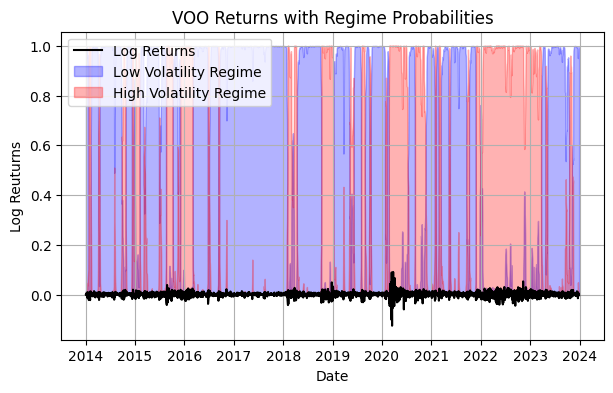

In [15]:
# To visalise when the market is in bull/bear periods. 
# can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(market_data):
    """
    Plots the regime probabilities over 10-year period, highlighting periods of low (purple) and high volatility (red).

    Parameters:
        market_data (pd.DataFrame): DataFrame containing market data with 'Returns' column for log returns.
    """
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(market_data. index, market_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    plt.grid()
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(market_data)

### Run Black Litterman Model

The Black Litterman Model is then called with all previous values, including the covariance matrix, prior, fear-greed generated views, picking matrix, omega, Markov-generated view confidences, tau, and delta.

To show that absolute views have not been used for the model, this has been explicitly set to 'None'. For the omega, Idzorek's method is employed (this is what requires the picking matrix to be defined). In the case that the number of views matches the number of tickers, a picking matrix wouldn't be necessary, as this would have an implicit mapping.

In [17]:
bl = BlackLittermanModel(
    covariance_matrix,
    pi=prior,
    absolute_views=None,
    Q=fg_scores_df,
    P=None,
    omega="idzorek",
    view_confidences=generated_confidences,
    tau=0.025,
    risk_aversion=delta
)

### Calculate Posterior Returns

Posterior returns are then calculated based on the Black Litterman model which produces a posterior estimate of the returns vector.

In [18]:
posterior_returns = bl.bl_returns()
posterior_returns

Ticker
AMD     0.156792
AMZN    0.186510
INTC    0.135191
META    0.170367
NVDA    0.112724
RIVN    0.139744
TSLA    0.099110
dtype: float64

The returns are difficult to visualise on their own, so these are added to a Pandas series alongside the Prior (market implied) and the views determined by the investor so the correlation between the values can be understood. 

In [19]:
views_series = pd.Series(normalized_values)

returns_df = pd.DataFrame([prior, posterior_returns, views_series], index=["Prior", "Posterior", "Views"]).T
returns_df

,Prior,Posterior,Views
AMD,0.003118,0.156792,0.097207
AMZN,0.002401,0.186510,0.135615
INTC,0.001552,0.135191,0.139511
META,0.002852,0.170367,0.170498
NVDA,0.003590,0.112724,0.187852
RIVN,0.003259,0.139744,0.111694
TSLA,0.002966,0.099110,0.157623


<Axes: >

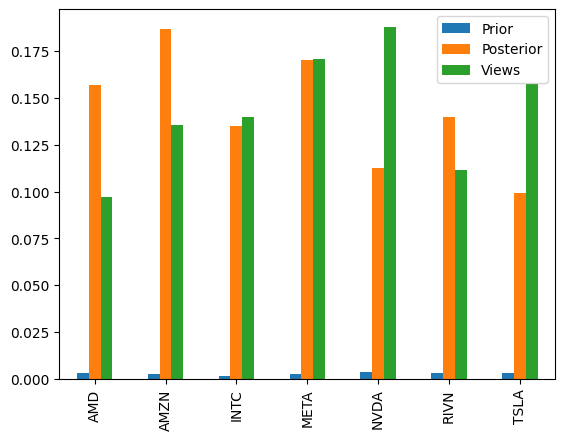

In [20]:
# For better understanding of the above series
# the correlation between the three values are plotted on a bar graph
returns_df.plot.bar()

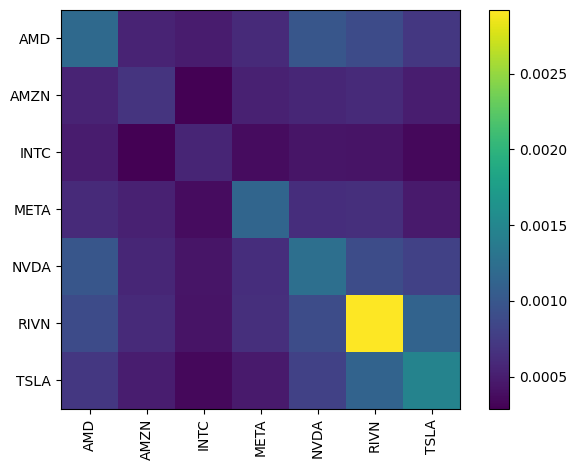

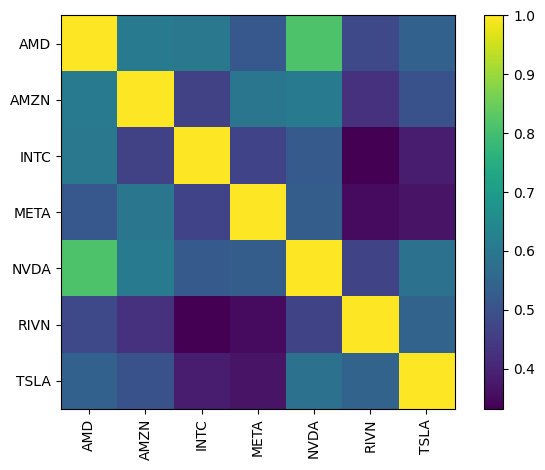

In [21]:
# Calculation of the new posterior covariance matrix
posterior_cov = bl.bl_cov()

# Alongside the plotted matrices
# for the correlation and covariance visualisations
covariance_plot = plotting.plot_covariance(posterior_cov, plot_correlation=False)
correlation_plot = plotting.plot_covariance(posterior_cov, plot_correlation=True)

### Efficient Frontier Weights

The following section is used to generate the allocation weights based on the Black Litterman returns and posterior covariance matrix. The weights are optimised for both Minimum Variance and Max Sharpe portfolios, which can be used as per the investor's risk tolerance and personal strategy.

The allocations per optimised weights are visualised further down to give a better understanding of how each strategy allocates the given assets.

#### Minimum Volatility

In [22]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_1 = EfficientFrontier(posterior_returns, posterior_cov)

# Retrieve the Minimum Volatilty portfolio weights
min_vol_weights = ef_1.min_volatility()

# Cleaned weights to ensure they are rounded and sum to 1
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37582),
             ('INTC', 0.57302),
             ('META', 0.01451),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03664)])

#### Max Sharpe

In [23]:
# Initialises the Efficient Frontier 
# using the posterior returns and covariance matrix
ef_2 = EfficientFrontier(posterior_returns, posterior_cov)

# Retrieve the Max Sharpe portfolio weights
max_sharpe_weights = ef_2.max_sharpe()

# Clean the weights to ensure they are rounded and sum to 1
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.6084),
             ('INTC', 0.3637),
             ('META', 0.0279),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

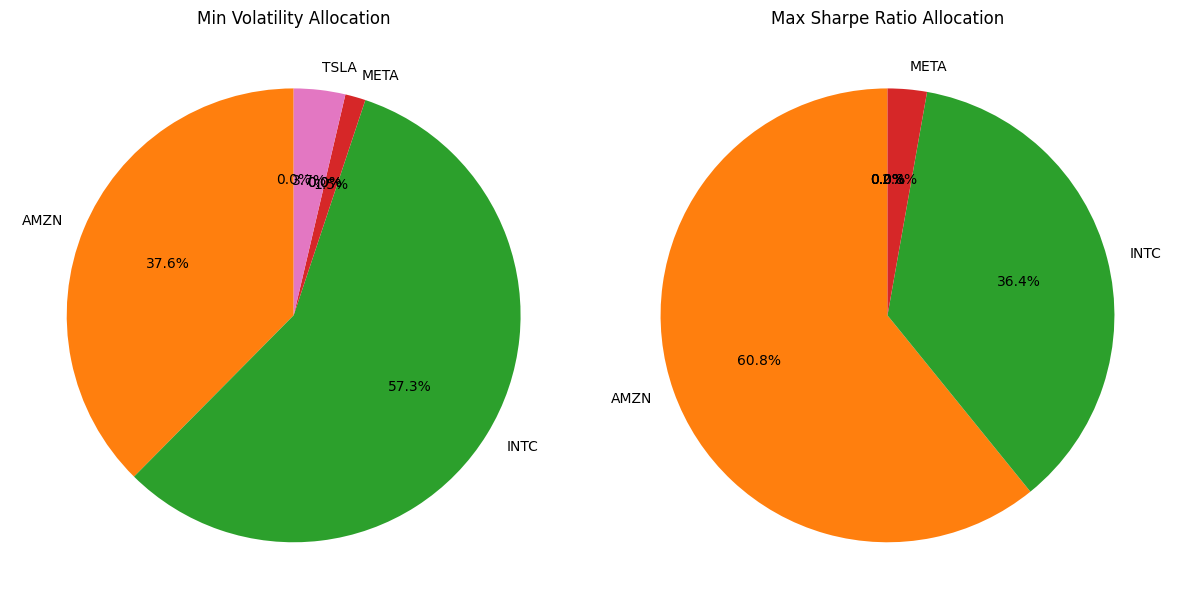

In [24]:
# Set the subplots for both pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility allocation
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Min Volatility Allocation"
)

# Plot Max Sharpe allocation
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Ratio Allocation"
)

plt.tight_layout()
plt.show()

### Portfolio Performance

The above allocations are effectively meaningless without an understanding of the annualised performance and risk-adjusted performance. The following section follows the same pattern of optimising for both Min Volatility portfolio and a Max Sharpe portfolio, and utilises the PyPortfolioOpt 'portfolio_performance' function to gauge the portfolio performance for each optimisation.

To breakdown the performance metrics:
- Expected annual return: The expected returns based on the given allocation
- Annual volatility: Used to gauge how risky the allocation is. A more diverse allocation can typically expect to have a lower volatility since the risk is distributed. For the default assets used in this notebook, since they are all in the tech sector, they are more likely to have a higher volatility.
- Sharpe ratio: Used to measure the returns per unit of risk. A higher ratio is better, where anything above 3 is typically considered very good.

#### Minimum Volatility Performance

In [25]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 15.4%
Annual volatility: 2.1%
Sharpe Ratio: 7.26


(np.float64(0.1536663701112608),
 np.float64(0.021168842963663212),
 np.float64(7.259082150830469))

#### Max Sharpe Performance

In [26]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 16.7%
Annual volatility: 2.2%
Sharpe Ratio: 7.63


(np.float64(0.1673952662676879),
 np.float64(0.0219498082946668),
 np.float64(7.6262746362281595))

### Get Discrete Allocation (DA)

The discrete allocation is retrieved for both the Min Volatility and Max Sharpe portfolios based on a £10,000 portfolio. This allows you to determine the number of shares to buy for each stock, which is helpful to use for a loose translation for a real world portfolio. This is not to be confused with a continuous allocation, which instead allows the investor to purchase fractional (partial) shares.

#### Min Volatility DA

In [27]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.376
INTC: allocated 0.570, desired 0.573
META: allocated 0.000, desired 0.015
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.037
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [28]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

# Quantities of shares that should be bought 
# to have a 10,000£ portfolio
print(allocation)

Funds remaining: 25.73
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.609, desired 0.608
INTC: allocated 0.353, desired 0.364
META: allocated 0.035, desired 0.028
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.002, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.005
{'AMZN': 40, 'INTC': 71, 'META': 1, 'RIVN': 1}


## Sensitivity Analysis

To validate the robustness of each model variant, the input sensitivity of several parameters must be tested to ensure no anomoloies in the data are produced with varying input values.

The following parameters will be validated based on a reasonable range for each value, such that the variance of the model's output can be assessed: 

- Relative views (key parameter for each variant)
- View confidences (key parameter for each variant)
- Prior
- Tau - Currently set to 0.025 as per Idzorek's recommendation, however it would be interesting to see how this affects each model when increased/decreased.

#### Sensitivity to Tau (Uncertainty in Prior)

The first parameter to validate is the effect of tau on the portfolio i.e. what is the uncertainty of the prior? The range of values in tau_values intends to tilt the portfolio either towards the prior or the views based on the level of uncertainty.

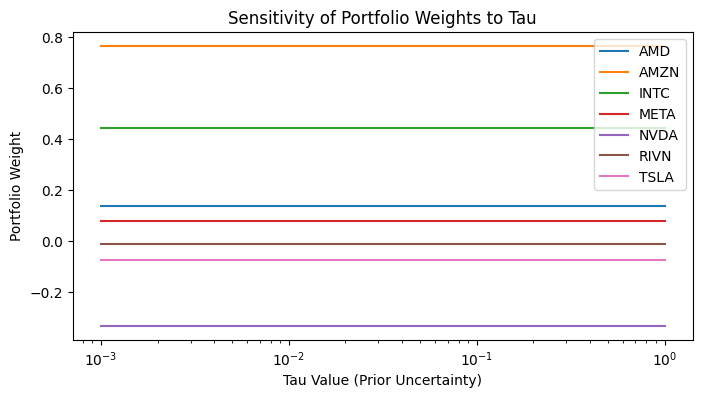

In [30]:
# Log scale from 0.001 to 1 for tau values
tau_values = np.logspace(-3, 0, 5)
results = []

for tau in tau_values:
    bl_model = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior, 
        absolute_views=None, 
        Q=fg_scores_df, 
        P=None, 
        omega="idzorek", 
        view_confidences=generated_confidences, 
        tau=tau, # <-- Using the new Tau
        risk_aversion=delta
    )
    posterior_weights = bl_model.bl_weights()
    results.append(posterior_weights)

posterior_weights_series = pd.Series(posterior_weights)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(posterior_weights_series.index):
    plt.plot(tau_values, [res[ticker] for res in results], label=ticker)

plt.xscale("log")
plt.xlabel("Tau Value (Prior Uncertainty)")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Tau")
plt.legend()
plt.show()

#### Sensitivity to Prior

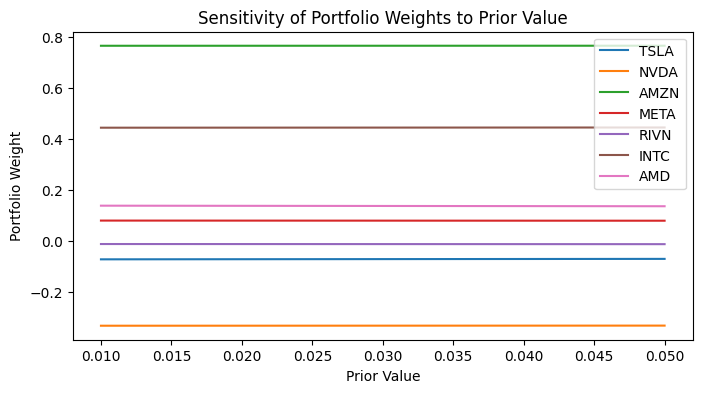

In [32]:
prior_values = np.linspace(0.01, 0.05, 5)
results_prior = []

for prior_value in prior_values:
    prior_test = pd.Series(prior_value, index=tickers)
    
    bl_model_prior = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior_test, # <-- Using the new Prior
        absolute_views=None, 
        Q=fg_scores_df, 
        P=None, 
        omega="idzorek", 
        view_confidences=generated_confidences, 
        tau=tau, 
        risk_aversion=delta
    )
    posterior_weights_prior = bl_model_prior.bl_weights()
    results_prior.append(posterior_weights_prior)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot(prior_values, [res[ticker] for res in results_prior], label=ticker)

plt.xlabel("Prior Value")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Prior Value")
plt.legend()
plt.show()

#### Sensitivity to Relative Views

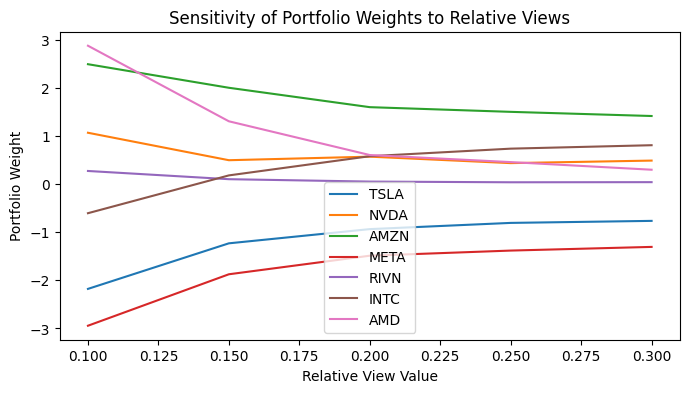

In [33]:
# Test sets of relative investor views
relative_views_range = [
    np.array([0.10, 0.05, 0.02, -0.03, 0.08, 0.05, -0.02]).reshape(-1, 1),
    np.array([0.15, 0.10, 0.05, -0.05, 0.12, 0.07, -0.03]).reshape(-1, 1),
    np.array([0.20, 0.15, 0.10, -0.07, 0.18, 0.09, -0.04]).reshape(-1, 1),
    np.array([0.25, 0.20, 0.15, -0.10, 0.22, 0.11, -0.05]).reshape(-1, 1),
    np.array([0.30, 0.25, 0.20, -0.12, 0.28, 0.14, -0.06]).reshape(-1, 1)
]
results_views = []

for views in relative_views_range:
    bl_model_views = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior, 
        absolute_views=None, 
        Q=views, # <-- Using the test set of investor views
        P=None, 
        omega="idzorek", 
        view_confidences=generated_confidences, 
        tau=tau, 
        risk_aversion=delta
    )
    posterior_weights_views = bl_model_views.bl_weights()
    results_views.append(posterior_weights_views)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot([views[0][0] for views in relative_views_range], [res[ticker] for res in results_views], label=ticker)

plt.xlabel("Relative View Value")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Relative Views")
plt.legend()
plt.show()

#### Sensitivity to View Confidence Levels

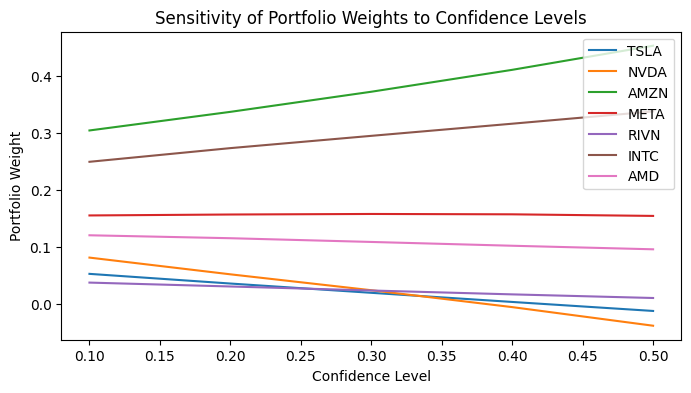

In [34]:
# Sets of view confidence levels
view_confidences = [
    np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
    np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]),
    np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]),
    np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]),
    np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
]
results_confidence_levels = []

for test_confidences in view_confidences:
    bl_model_views = BlackLittermanModel(
        cov_matrix=covariance_matrix,
        pi=prior, 
        absolute_views=None, 
        Q=fg_scores_df,
        P=None, 
        omega="idzorek", 
        view_confidences=test_confidences, # <-- Using the test set of view confidences levels
        tau=tau,
        risk_aversion=delta
    )
    posterior_weights_views = bl_model_views.bl_weights()
    results_confidence_levels.append(posterior_weights_views)

plt.figure(figsize=(8, 4))
for i, ticker in enumerate(tickers):
    plt.plot([conf[0] for conf in view_confidences], [res[ticker] for res in results_confidence_levels], label=ticker)

plt.xlabel("Confidence Level")
plt.ylabel("Portfolio Weight")
plt.title("Sensitivity of Portfolio Weights to Confidence Levels")
plt.legend()
plt.show()